<a href="https://colab.research.google.com/github/mcgmed/Tensorflow/blob/main/Using-Tensorflow-to-Create-Text/Irish_Song_Improving_the_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np 
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/irish-lyrics-eof.txt \
    -O /tmp/irish-lyrics-eof.txt

--2022-11-30 19:34:42--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/irish-lyrics-eof.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.119.128, 108.177.126.128, 108.177.127.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.119.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68970 (67K) [text/plain]
Saving to: ‘/tmp/irish-lyrics-eof.txt’

/tmp/irish-lyrics-e 100%[===================>]  67.35K  --.-KB/s    in 0.09s   

2022-11-30 19:34:42 (736 KB/s) - ‘/tmp/irish-lyrics-eof.txt’ saved [68970/68970]



In [3]:
tokenizer = Tokenizer()
max_sequence_len = 6
sentences=[]
alltext=[]
data = open('/tmp/irish-lyrics-eof.txt').read()
corpus = data.lower()
alltext.append(corpus)
words = corpus.split(" ")
range_size = len(words)-max_sequence_len
for i in range(0, range_size):
  thissentence=""
  for word in range(0, max_sequence_len-1):
    word = words[i+word]
    thissentence = thissentence + word
    thissentence = thissentence + " "
  sentences.append(thissentence)

oov_tok = ""
vocab_size=2700
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok, split=" ", char_level=False)
tokenizer.fit_on_texts(alltext)
total_words = len(tokenizer.word_index) + 1

word_index = tokenizer.word_index
print(f'Instances from word index: {list(word_index.items())[:6]}')
print(f'Total word number is: {total_words}')

input_sequences = []
for line in sentences:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)

# pad sequences 
#max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
xs, labels = input_sequences[:,:-1],input_sequences[:,-1]

ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)

Instances from word index: [('', 1), ('the', 2), ('and', 3), ('i', 4), ('to', 5), ('a', 6)]
Total word number is: 2691


In [4]:
print(xs.shape)

(56643, 5)


In [5]:
print(xs[:20])

[[   0    0    0    0   52]
 [   0    0    0   52   13]
 [   0    0   52   13   97]
 [   0   52   13   97 1218]
 [   0    0    0    0   13]
 [   0    0    0   13   97]
 [   0    0   13   97 1218]
 [   0   13   97 1218   49]
 [   0    0    0    0   97]
 [   0    0    0   97 1218]
 [   0    0   97 1218   49]
 [   0   97 1218   49    3]
 [  97 1218   49    3   70]
 [   0    0    0    0 1218]
 [   0    0    0 1218   49]
 [   0    0 1218   49    3]
 [   0 1218   49    3   70]
 [1218   49    3   70    3]
 [   0    0    0    0   49]
 [   0    0    0   49    3]]


In [7]:
model = Sequential()
model.add(Embedding(total_words, 16, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(32, return_sequences=True)))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(total_words, activation='softmax'))
adam = Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
history = model.fit(xs, ys, epochs=50)
#model.save("bidiirish2.h5")

Epoch 1/50
1771/1771 [==============================] - 24s 11ms/step - loss: 6.0307 - accuracy: 0.0820
Epoch 2/50
1771/1771 [==============================] - 18s 10ms/step - loss: 5.1277 - accuracy: 0.1344
Epoch 3/50
1771/1771 [==============================] - 18s 10ms/step - loss: 4.4708 - accuracy: 0.1786
Epoch 4/50
1771/1771 [==============================] - 19s 11ms/step - loss: 3.9656 - accuracy: 0.2224
Epoch 5/50
1771/1771 [==============================] - 18s 10ms/step - loss: 3.5725 - accuracy: 0.2646
Epoch 6/50
1771/1771 [==============================] - 18s 10ms/step - loss: 3.2816 - accuracy: 0.3011
Epoch 7/50
1771/1771 [==============================] - 18s 10ms/step - loss: 3.0663 - accuracy: 0.3313
Epoch 8/50
1771/1771 [==============================] - 18s 10ms/step - loss: 2.8886 - accuracy: 0.3598
Epoch 9/50
1771/1771 [==============================] - 18s 10ms/step - loss: 2.7513 - accuracy: 0.3812
Epoch 10/50
1771/1771 [==============================] - 18s 10m

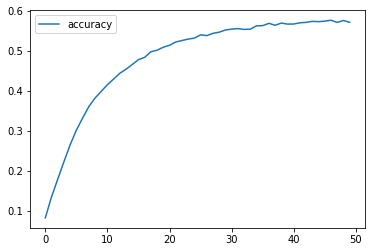

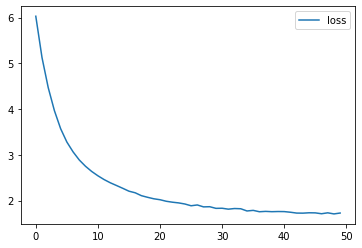

In [8]:
def plot_graphs(history, string):
  plt.plot(history.history[string]);
  plt.legend([string]);
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [9]:
seed_text = "sweet jeremy saw dublin"

token_list = tokenizer.texts_to_sequences([seed_text])[0]
token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
predicted = np.argmax(model.predict(token_list), axis=-1)
pred_classes=model.predict(token_list)
print(pred_classes.reshape(-1)[predicted])
print(predicted)
for word, index in tokenizer.word_index.items():
	if index == predicted:
		print(word)
		break

1/1 [==============================] - 0s 17ms/step
[0.32880518]
[72]
town


In [10]:
seed_text = "are you feeling lucky"
next_words=100

for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = np.argmax(model.predict(token_list),axis=1)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word

print(seed_text)

1/1 [==============================] - 0s 21ms/step
are you feeling lucky and please girded on and oh oh come when i was born cut a stout black old johnny morn the blades of liverpool when we paid a flying let them know i was born cut a stout black old johnny morn the blades of liverpool when we paid a flying let them know i was born cut a stout black old johnny morn the blades of liverpool when we paid a flying let them know i was born cut a stout black old johnny morn the blades of liverpool when we paid a flying let them know i was born
